#Finding an Edge in Sports Betting

##Pre-Model Work

###Set Up

In [1]:
!pip install nfl_data_py

In [2]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from collections import defaultdict

In [3]:
#all data entries have a spread_line value and game margin (target variable)
#game margin is defined as home team points minus away team points, so it can be negative
match_df = nfl.import_schedules([year for year in range(2000, 2025)])

#check for nan values
print(match_df.shape)
pd.set_option("display.max_columns", None)
matches_df = match_df.dropna(subset=['spread_line', 'result'])
print(match_df.shape)

#move the result and the spread line towards the front of the df for visibility
spread_line = match_df.pop('spread_line')
match_df.insert(1, spread_line.name, spread_line)

game_margin = match_df.pop('result')
match_df.insert(1, 'game_margin', game_margin)

match_df

(6732, 46)
(6732, 46)


game_id  game_margin  spread_line  season game_type  week  \
259    2000_01_SF_ATL          8.0          6.5    2000       REG     1   
260   2000_01_JAX_CLE        -20.0        -10.5    2000       REG     1   
261    2000_01_IND_KC        -13.0         -3.5    2000       REG     1   
262   2000_01_CHI_MIN          3.0          4.5    2000       REG     1   
263     2000_01_TB_NE         -5.0         -3.0    2000       REG     1   
...               ...          ...          ...     ...       ...   ...   
6986   2024_20_LA_PHI          6.0          7.0    2024       DIV    20   
6987  2024_20_BAL_BUF          2.0         -1.5    2024       DIV    20   
6988  2024_21_WAS_PHI         32.0          6.0    2024       CON    21   
6989   2024_21_BUF_KC          3.0          1.5    2024       CON    21   
6990   2024_22_KC_PHI         18.0         -1.5    2024        SB    22   

         gameday weekday gametime away_team  away_score home_team  home_score  \
259   2000-09-03  Sunday    13:00        SF        28.0       ATL        36.0   
260   2000-09-03  Sunday    13:00       JAX        27.0       CLE         7.0   
261   2000-09-03  Sunday    13:00       IND        27.0        KC        14.0   
262   2000-09-03  Sunday    13:00       CHI        27.0       MIN        30.0   
263   2000-09-03  Sunday    13:00        TB        21.0        NE        16.0   
...          ...     ...      ...       ...         ...       ...         ...   
6986  2025-01-19  Sunday    15:00        LA        22.0       PHI        28.0   
6987  2025-01-19  Sunday    18:30       BAL        25.0       BUF        27.0   
6988  2025-01-26  Sunday    15:00       WAS        23.0       PHI        55.0   
6989  2025-01-26  Sunday    18:30       BUF        29.0        KC        32.0   
6990  2025-02-09  Sunday    18:30        KC        22.0       PHI        40.0   

     location  total  overtime  old_game_id     gsis nfl_detail_id  \
259      Home   64.0       0.0   2000090310    998.0           NaN   
260      Home   34.0       0.0   2000090306    994.0           NaN   
261      Home   41.0       0.0   2000090305    993.0           NaN   
262      Home   57.0       0.0   2000090303    991.0           NaN   
263      Home   37.0       0.0   2000090312   1000.0           NaN   
...       ...    ...       ...          ...      ...           ...   
6986     Home   50.0       0.0   2025011900  59837.0           NaN   
6987     Home   52.0       0.0   2025011901  59838.0           NaN   
6988     Home   78.0       0.0   2025012600  59839.0           NaN   
6989     Home   61.0       0.0   2025012601  59840.0           NaN   
6990  Neutral   62.0       0.0   2025020900  59841.0           NaN   

               pfr  pff         espn  ftn  away_rest  home_rest  \
259   200009030atl  NaN  200903001.0  NaN          7          7   
260   200009030cle  NaN  200903005.0  NaN          7          7   
261   200009030kan  NaN  200903012.0  NaN          7          7   
262   200009030min  NaN  200903016.0  NaN          7          7   
263   200009030nwe  NaN  200903017.0  NaN          7          7   
...            ...  ...          ...  ...        ...        ...   
6986  202501190phi  NaN  401671937.0  NaN          6          7   
6987  202501190buf  NaN  401671886.0  NaN          8          7   
6988  202501260phi  NaN  401671888.0  NaN          8          7   
6989  202501260kan  NaN  401671887.0  NaN          7          8   
6990  202502090phi  NaN  401671889.0  NaN         14         14   

      away_moneyline  home_moneyline  away_spread_odds  home_spread_odds  \
259              NaN             NaN               NaN               NaN   
260              NaN             NaN               NaN               NaN   
261              NaN             NaN               NaN               NaN   
262              NaN             NaN               NaN               NaN   
263              NaN             NaN               NaN               NaN   
...              ...             ...  

###Data Cleaning / Data Manipulation

In [4]:
#add a feature to include if a match is a playoff or regular season event -> regular season games tend to have more noise, if teams get super far behind in the regular season they may pull their starters, but in the playoffs all teams try the hardest they possibly can
match_df['is_playoff'] = match_df['game_type'] != 'REG'
match_df

game_id  game_margin  spread_line  season game_type  week  \
259    2000_01_SF_ATL          8.0          6.5    2000       REG     1   
260   2000_01_JAX_CLE        -20.0        -10.5    2000       REG     1   
261    2000_01_IND_KC        -13.0         -3.5    2000       REG     1   
262   2000_01_CHI_MIN          3.0          4.5    2000       REG     1   
263     2000_01_TB_NE         -5.0         -3.0    2000       REG     1   
...               ...          ...          ...     ...       ...   ...   
6986   2024_20_LA_PHI          6.0          7.0    2024       DIV    20   
6987  2024_20_BAL_BUF          2.0         -1.5    2024       DIV    20   
6988  2024_21_WAS_PHI         32.0          6.0    2024       CON    21   
6989   2024_21_BUF_KC          3.0          1.5    2024       CON    21   
6990   2024_22_KC_PHI         18.0         -1.5    2024        SB    22   

         gameday weekday gametime away_team  away_score home_team  home_score  \
259   2000-09-03  Sunday    13:00        SF        28.0       ATL        36.0   
260   2000-09-03  Sunday    13:00       JAX        27.0       CLE         7.0   
261   2000-09-03  Sunday    13:00       IND        27.0        KC        14.0   
262   2000-09-03  Sunday    13:00       CHI        27.0       MIN        30.0   
263   2000-09-03  Sunday    13:00        TB        21.0        NE        16.0   
...          ...     ...      ...       ...         ...       ...         ...   
6986  2025-01-19  Sunday    15:00        LA        22.0       PHI        28.0   
6987  2025-01-19  Sunday    18:30       BAL        25.0       BUF        27.0   
6988  2025-01-26  Sunday    15:00       WAS        23.0       PHI        55.0   
6989  2025-01-26  Sunday    18:30       BUF        29.0        KC        32.0   
6990  2025-02-09  Sunday    18:30        KC        22.0       PHI        40.0   

     location  total  overtime  old_game_id     gsis nfl_detail_id  \
259      Home   64.0       0.0   2000090310    998.0           NaN   
260      Home   34.0       0.0   2000090306    994.0           NaN   
261      Home   41.0       0.0   2000090305    993.0           NaN   
262      Home   57.0       0.0   2000090303    991.0           NaN   
263      Home   37.0       0.0   2000090312   1000.0           NaN   
...       ...    ...       ...          ...      ...           ...   
6986     Home   50.0       0.0   2025011900  59837.0           NaN   
6987     Home   52.0       0.0   2025011901  59838.0           NaN   
6988     Home   78.0       0.0   2025012600  59839.0           NaN   
6989     Home   61.0       0.0   2025012601  59840.0           NaN   
6990  Neutral   62.0       0.0   2025020900  59841.0           NaN   

               pfr  pff         espn  ftn  away_rest  home_rest  \
259   200009030atl  NaN  200903001.0  NaN          7          7   
260   200009030cle  NaN  200903005.0  NaN          7          7   
261   200009030kan  NaN  200903012.0  NaN          7          7   
262   200009030min  NaN  200903016.0  NaN          7          7   
263   200009030nwe  NaN  200903017.0  NaN          7          7   
...            ...  ...          ...  ...        ...        ...   
6986  202501190phi  NaN  401671937.0  NaN          6          7   
6987  202501190buf  NaN  401671886.0  NaN          8          7   
6988  202501260phi  NaN  401671888.0  NaN          8          7   
6989  202501260kan  NaN  401671887.0  NaN          7          8   
6990  202502090phi  NaN  401671889.0  NaN         14         14   

      away_moneyline  home_moneyline  away_spread_odds  home_spread_odds  \
259              NaN             NaN               NaN               NaN   
260              NaN             NaN               NaN               NaN   
261              NaN             NaN               NaN               NaN   
262              NaN             NaN               NaN               NaN   
263              NaN             NaN               NaN               NaN   
...              ...             ...  

In [5]:
#add a feature to include if a match is the last week of the regular season - teams tend to rest starters either to prepare for the playoffs or because they are already out of playoff contention

#gather up the final week of the regular season from 2000 to 2024...keeps code flexible but from knowledge 2000 through 2020 is 17 weeks and the last 4 years are 18 weeks. In the future they may extend the season further
final_week = (match_df[match_df['is_playoff'] == False].groupby('season')['week'].max().reset_index().rename(columns={'week': 'final_week_of_reg_szn'}))
final_week.head()

season  final_week_of_reg_szn
0    2000                     17
1    2001                     17
2    2002                     17
3    2003                     17
4    2004                     17

In [6]:
#merge on the season, then create feature to flag for the final week of the regular season
match_df = match_df.merge(final_week, on='season', how='left')
match_df['is_final_week'] = (match_df['is_playoff'] == False) & (match_df['week'] == match_df['final_week_of_reg_szn'])

match_df

game_id  game_margin  spread_line  season game_type  week  \
0      2000_01_SF_ATL          8.0          6.5    2000       REG     1   
1     2000_01_JAX_CLE        -20.0        -10.5    2000       REG     1   
2      2000_01_IND_KC        -13.0         -3.5    2000       REG     1   
3     2000_01_CHI_MIN          3.0          4.5    2000       REG     1   
4       2000_01_TB_NE         -5.0         -3.0    2000       REG     1   
...               ...          ...          ...     ...       ...   ...   
6727   2024_20_LA_PHI          6.0          7.0    2024       DIV    20   
6728  2024_20_BAL_BUF          2.0         -1.5    2024       DIV    20   
6729  2024_21_WAS_PHI         32.0          6.0    2024       CON    21   
6730   2024_21_BUF_KC          3.0          1.5    2024       CON    21   
6731   2024_22_KC_PHI         18.0         -1.5    2024        SB    22   

         gameday weekday gametime away_team  away_score home_team  home_score  \
0     2000-09-03  Sunday    13:00        SF        28.0       ATL        36.0   
1     2000-09-03  Sunday    13:00       JAX        27.0       CLE         7.0   
2     2000-09-03  Sunday    13:00       IND        27.0        KC        14.0   
3     2000-09-03  Sunday    13:00       CHI        27.0       MIN        30.0   
4     2000-09-03  Sunday    13:00        TB        21.0        NE        16.0   
...          ...     ...      ...       ...         ...       ...         ...   
6727  2025-01-19  Sunday    15:00        LA        22.0       PHI        28.0   
6728  2025-01-19  Sunday    18:30       BAL        25.0       BUF        27.0   
6729  2025-01-26  Sunday    15:00       WAS        23.0       PHI        55.0   
6730  2025-01-26  Sunday    18:30       BUF        29.0        KC        32.0   
6731  2025-02-09  Sunday    18:30        KC        22.0       PHI        40.0   

     location  total  overtime  old_game_id     gsis nfl_detail_id  \
0        Home   64.0       0.0   2000090310    998.0           NaN   
1        Home   34.0       0.0   2000090306    994.0           NaN   
2        Home   41.0       0.0   2000090305    993.0           NaN   
3        Home   57.0       0.0   2000090303    991.0           NaN   
4        Home   37.0       0.0   2000090312   1000.0           NaN   
...       ...    ...       ...          ...      ...           ...   
6727     Home   50.0       0.0   2025011900  59837.0           NaN   
6728     Home   52.0       0.0   2025011901  59838.0           NaN   
6729     Home   78.0       0.0   2025012600  59839.0           NaN   
6730     Home   61.0       0.0   2025012601  59840.0           NaN   
6731  Neutral   62.0       0.0   2025020900  59841.0           NaN   

               pfr  pff         espn  ftn  away_rest  home_rest  \
0     200009030atl  NaN  200903001.0  NaN          7          7   
1     200009030cle  NaN  200903005.0  NaN          7          7   
2     200009030kan  NaN  200903012.0  NaN          7          7   
3     200009030min  NaN  200903016.0  NaN          7          7   
4     200009030nwe  NaN  200903017.0  NaN          7          7   
...            ...  ...          ...  ...        ...        ...   
6727  202501190phi  NaN  401671937.0  NaN          6          7   
6728  202501190buf  NaN  401671886.0  NaN          8          7   
6729  202501260phi  NaN  401671888.0  NaN          8          7   
6730  202501260kan  NaN  401671887.0  NaN          7          8   
6731  202502090phi  NaN  401671889.0  NaN         14         14   

      away_moneyline  home_moneyline  away_spread_odds  home_spread_odds  \
0                NaN             NaN               NaN               NaN   
1                NaN             NaN               NaN               NaN   
2                NaN             NaN               NaN               NaN   
3                NaN             NaN               NaN               NaN   
4                NaN             NaN               NaN               NaN   
...              ...             ...  

In [7]:
#sanity check
season2023_df = match_df[match_df['season'] == 2023]
season2023_week18_df = season2023_df[season2023_df['week'] == 18]
season2023_week18_df.head()

game_id  game_margin  spread_line  season game_type  week  \
6418  2023_18_PIT_BAL         -7.0         -3.0    2023       REG    18   
6419  2023_18_HOU_IND         -4.0         -1.5    2023       REG    18   
6420   2023_18_TB_CAR         -9.0         -5.0    2023       REG    18   
6421  2023_18_CLE_CIN         17.0          7.5    2023       REG    18   
6422  2023_18_MIN_DET         10.0          3.5    2023       REG    18   

         gameday   weekday gametime away_team  away_score home_team  \
6418  2024-01-06  Saturday    16:30       PIT        17.0       BAL   
6419  2024-01-06  Saturday    20:15       HOU        23.0       IND   
6420  2024-01-07    Sunday    13:00        TB         9.0       CAR   
6421  2024-01-07    Sunday    13:00       CLE        14.0       CIN   
6422  2024-01-07    Sunday    13:00       MIN        20.0       DET   

      home_score location  total  overtime  old_game_id     gsis  \
6418        10.0     Home   27.0       0.0   2024010600  59430.0   
6419        19.0     Home   42.0       0.0   2024010601  59435.0   
6420         0.0     Home    9.0       0.0   2024010705  59431.0   
6421        31.0     Home   45.0       0.0   2024010701  59432.0   
6422        30.0     Home   50.0       0.0   2024010703  59433.0   

     nfl_detail_id           pfr  pff         espn  ftn  away_rest  home_rest  \
6418           NaN  202401060rav  NaN  401547639.0  NaN          6          6   
6419           NaN  202401060clt  NaN  401547644.0  NaN          6          6   
6420           NaN  202401070car  NaN  401547640.0  NaN          7          7   
6421           NaN  202401070cin  NaN  401547641.0  NaN         10          7   
6422           NaN  202401070det  NaN  401547642.0  NaN          7          8   

      away_moneyline  home_moneyline  away_spread_odds  home_spread_odds  \
6418          -155.0           130.0            -105.0            -115.0   
6419          -125.0           105.0            -110.0            -110.0   
6420          -245.0           200.0            -105.0            -115.0   
6421           285.0          -360.0            -115.0            -105.0   
6422           170.0          -205.0            -102.0            -118.0   

      total_line  under_odds  over_odds  div_game      roof    surface  temp  \
6418        34.0      -110.0     -110.0         1  outdoors      grass  38.0   
6419        47.5      -108.0     -112.0         1    closed  fieldturf   NaN   
6420        36.5      -110.0     -110.0         1  outdoors      grass  54.0   
6421        37.0      -112.0     -108.0         1  outdoors  fieldturf  38.0   
6422        47.5      -110.0     -110.0         1      dome  fieldturf   NaN   

      wind  away_qb_id  home_qb_id    away_qb_name     home_qb_name  \
6418  15.0  00-0034771  00-0035993   Mason Rudolph    Tyler Huntley   
6419   NaN  00-0039163  00-0035289     C.J. Stroud  Gardner Minshew   
6420  19.0  00-0034855  00-0039150  Baker Mayfield      Bryce Young   
6421  12.0  00-0032436  00-0035100    Jeff Driskel    Jake Browning   
6422   NaN  00-0033319  00-0033106    Nick Mullens       Jared Goff   

           away_coach      home_coach         referee stadium_id  \
6418      Mike Tomlin   John Harbaugh      Brad Allen      BAL00   
6419     DeMeco Ryans  Shane Steichen   Bill Vinovich      IND00   
6420      Todd Bowles     Chris Tabor  Clete Blakeman      CAR00   
6421  Kevin Stefanski      Zac Taylor        Alan Eck      CIN00   
6422  Kevin O'Connell    Dan Campbell     Brad Rogers      DET00   

                      stadium  is_playoff  final_week_of_reg_szn  \
6418         M&T Bank Stadium       False                     18   
6419        Lucas Oil Stadium       False                     18   
6420  Bank of America Stadium       False                     18   
6421           Paycor Stadium       False                     18   
6422               Ford Field       False                     18   

      is_final_week  
6418           True  
6419         

In [8]:
#some of the features we have are great, but from general understanding of sports betting, team performance is a factor that is missing from our current dataset
#in addition, football is a violent sport, injuries are a key factor that can impact the result and spread of a game
#important to remember there are definetly edge cases where a key player gets hurt in the middle of the game that we can not account for in our predictions - this adds to the noise of the data

#hard to find true injury values, there are just so many players to account for
#to simlify this process we will look at if there was a QB switch from the preivous week to the current match. This could indicate the QB was injured in the previous game or is being benched.

#gather up home qbs and away qbs
home_qbs = match_df[['game_id', 'season', 'week', 'home_team', 'home_qb_name']].rename(
    columns={'home_team': 'team', 'home_qb_name': 'qb_name'}
)
away_qbs = match_df[['game_id', 'season', 'week', 'away_team', 'away_qb_name']].rename(
    columns={'away_team': 'team', 'away_qb_name': 'qb_name'}
)

#concat them into a dataset that is just team and qbs of those teams each match
team_matches = pd.concat([home_qbs, away_qbs])
team_matches = team_matches.sort_values(['team', 'season', 'week'])

#check if the qb from last week is the same as the week before, if yes then qb_switch is true else false
team_matches['qb_switch'] = (team_matches.groupby('team')['qb_name'].transform(lambda x: x != x.shift(1)).fillna(False))
#check to make sure week 1 is always false since it is the first week
team_matches.loc[team_matches['week'] == True, 'qb_switch'] = False

#merge the dataset back to main dataset and make it based on home or away team for the event
match_df = match_df.merge(team_matches[['game_id', 'team', 'qb_switch']], left_on=['game_id', 'home_team'], right_on=['game_id', 'team'], how='left').rename(columns={'qb_switch': 'home_qb_switch'}).drop(columns='team')
match_df = match_df.merge(team_matches[['game_id', 'team', 'qb_switch']], left_on=['game_id', 'away_team'], right_on=['game_id', 'team'], how='left').rename(columns={'qb_switch': 'away_qb_switch'}).drop(columns='team')

match_df.head()

game_id  game_margin  spread_line  season game_type  week  \
0   2000_01_SF_ATL          8.0          6.5    2000       REG     1   
1  2000_01_JAX_CLE        -20.0        -10.5    2000       REG     1   
2   2000_01_IND_KC        -13.0         -3.5    2000       REG     1   
3  2000_01_CHI_MIN          3.0          4.5    2000       REG     1   
4    2000_01_TB_NE         -5.0         -3.0    2000       REG     1   

      gameday weekday gametime away_team  away_score home_team  home_score  \
0  2000-09-03  Sunday    13:00        SF        28.0       ATL        36.0   
1  2000-09-03  Sunday    13:00       JAX        27.0       CLE         7.0   
2  2000-09-03  Sunday    13:00       IND        27.0        KC        14.0   
3  2000-09-03  Sunday    13:00       CHI        27.0       MIN        30.0   
4  2000-09-03  Sunday    13:00        TB        21.0        NE        16.0   

  location  total  overtime  old_game_id    gsis nfl_detail_id           pfr  \
0     Home   64.0       0.0   2000090310   998.0           NaN  200009030atl   
1     Home   34.0       0.0   2000090306   994.0           NaN  200009030cle   
2     Home   41.0       0.0   2000090305   993.0           NaN  200009030kan   
3     Home   57.0       0.0   2000090303   991.0           NaN  200009030min   
4     Home   37.0       0.0   2000090312  1000.0           NaN  200009030nwe   

   pff         espn  ftn  away_rest  home_rest  away_moneyline  \
0  NaN  200903001.0  NaN          7          7             NaN   
1  NaN  200903005.0  NaN          7          7             NaN   
2  NaN  200903012.0  NaN          7          7             NaN   
3  NaN  200903016.0  NaN          7          7             NaN   
4  NaN  200903017.0  NaN          7          7             NaN   

   home_moneyline  away_spread_odds  home_spread_odds  total_line  under_odds  \
0             NaN               NaN               NaN        46.5         NaN   
1             NaN               NaN               NaN        38.5         NaN   
2             NaN               NaN               NaN        44.0         NaN   
3             NaN               NaN               NaN        46.5         NaN   
4             NaN               NaN               NaN        36.0         NaN   

   over_odds  div_game      roof    surface  temp  wind  away_qb_id  \
0        NaN         1      dome  astroturf   NaN   NaN  00-0005755   
1        NaN         1  outdoors      grass  78.0   6.0  00-0002110   
2        NaN         0  outdoors      grass  90.0   5.0  00-0010346   
3        NaN         1      dome  astroturf   NaN   NaN  00-0011044   
4        NaN         0  outdoors      grass  71.0   5.0  00-0009266   

   home_qb_id    away_qb_name      home_qb_name      away_coach  \
0  00-0002876     Jeff Garcia    Chris Chandler  Steve Mariucci   
1  00-0003535    Mark Brunell         Tim Couch    Tom Coughlin   
2  00-0006300  Peyton Manning       Elvis Grbac        Jim Mora   
3  00-0003739     Cade McNown  Daunte Culpepper     Dick Jauron   
4  00-0001361      Shaun King      Drew Bledsoe      Tony Dungy   

           home_coach         referee stadium_id  \
0          Dan Reeves    Walt Coleman      ATL00   
1        Chris Palmer    Bernie Kukar      CLE00   
2  Gunther Cunningham   Larry Nemmers      KAN00   
3        Dennis Green      Ed Hochuli      MIN00   
4      Bill Belichick  Jeff Triplette      BOS99   

                        stadium  is_playoff  final_week_of_reg_szn  \
0                  Georgia Dome       False                     17   
1      Cleveland Browns Stadium       False                     17   
2             Arrowhead Stadium       False                     17   
3  Hubert H. Humphrey Metrodome       False                     17   
4               Foxboro Stadium       False                     17   

   is_final_week  home_qb_switch  away_qb_switch  
0          False           False           False  
1          False           False           False  
2          False           

In [9]:
#rolling recent team performance
#pull in pbp data to acculate team statistics coming into a match
#pull data in 1 season at a time due to storage

pbp_df = []
for year in range(2000, 2025):
    pbp_szn = nfl.import_pbp_data([year])
    pbp_szn_run_pass = pbp_szn[pbp_szn['play_type'].isin(['run', 'pass']) & pbp_szn['posteam'].notna() & pbp_szn['defteam'].notna()]
    pbp_df.append(pbp_szn_run_pass)
pbp_run_pass = pd.concat(pbp_df, ignore_index=True)

2000 done.
Downcasting floats.
2001 done.
Downcasting floats.
2002 done.
Downcasting floats.
2003 done.
Downcasting floats.
2004 done.
Downcasting floats.
2005 done.
Downcasting floats.
2006 done.
Downcasting floats.
2007 done.
Downcasting floats.
2008 done.
Downcasting floats.
2009 done.
Downcasting floats.
2010 done.
Downcasting floats.
2011 done.
Downcasting floats.
2012 done.
Downcasting floats.
2013 done.
Downcasting floats.
2014 done.
Downcasting floats.
2015 done.
Downcasting floats.
2016 done.
Downcasting floats.
2017 done.
Downcasting floats.
2018 done.
Downcasting floats.
2019 done.
Downcasting floats.
2020 done.
Downcasting floats.
2021 done.
Downcasting floats.
2022 done.
Downcasting floats.
2023 done.
Downcasting floats.
2024 done.
Downcasting floats.


In [10]:
#aggregate epa, yards, plays per team (offense)
off_stats = (pbp_run_pass.groupby(['game_id', 'posteam']).agg(avg_epa=('epa', 'mean'), avg_yards=('yards_gained', 'mean'), play_count=('play_id', 'count')).reset_index())
off_stats = off_stats.merge(match_df[['game_id', 'season', 'week']], on='game_id', how='left')

#make it a rolling window of previous 5 games (shows recent offense team performanace)
for feature in ['avg_epa', 'avg_yards', 'play_count']:
    off_stats[f'rolling_{feature}'] = (off_stats.sort_values(['posteam', 'season', 'week']).groupby('posteam')[feature].transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean()))
off_stats = off_stats.rename(columns={'posteam': 'team'})
off_stats

game_id team   avg_epa  avg_yards  play_count  season  week  \
0      2000_01_ARI_NYG  ARI -0.083127   5.000000          71    2000     1   
1      2000_01_ARI_NYG  NYG  0.101295   6.076923          65    2000     1   
2      2000_01_BAL_PIT  BAL  0.030146   4.869565          69    2000     1   
3      2000_01_BAL_PIT  PIT -0.304014   3.844828          58    2000     1   
4      2000_01_CAR_WAS  CAR -0.069782   4.725490          51    2000     1   
...                ...  ...       ...        ...         ...     ...   ...   
13456   2024_21_BUF_KC   KC  0.269068   6.114754          61    2024    21   
13457  2024_21_WAS_PHI  PHI  0.398572   7.107692          65    2024    21   
13458  2024_21_WAS_PHI  WAS -0.088838   4.455696          79    2024    21   
13459   2024_22_KC_PHI   KC -0.341451   5.431373          51    2024    22   
13460   2024_22_KC_PHI  PHI  0.018603   5.208955          67    2024    22   

       rolling_avg_epa  rolling_avg_yards  rolling_play_count  
0                  NaN                NaN                 NaN  
1                  NaN                NaN                 NaN  
2                  NaN                NaN                 NaN  
3                  NaN                NaN                 NaN  
4                  NaN                NaN                 NaN  
...                ...                ...                 ...  
13456        -0.004269           4.823622                56.0  
13457         0.077039           5.350217                62.6  
13458         0.128645           5.663357                66.4  
13459         0.065030           5.189039                53.6  
13460         0.151505           5.819643                61.4  

[13461 rows x 10 columns]

In [11]:
#aggregate allowed epa, yards, plays
def_stats = (pbp_run_pass.groupby(['game_id', 'defteam']).agg(allowed_avg_epa=('epa', 'mean'), allowed_avg_yards=('yards_gained', 'mean'), allowed_play_count=('play_id', 'count')).reset_index())
def_stats = def_stats.merge(match_df[['game_id', 'season', 'week']], on='game_id', how='left')

#make it a rolling window of previous 5 games (shows recent defense team performance)
for feature in ['allowed_avg_epa', 'allowed_avg_yards', 'allowed_play_count']:
    def_stats[f'rolling_{feature}'] = (def_stats.sort_values(['defteam', 'season', 'week']).groupby('defteam')[feature].transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean()))
def_stats = def_stats.rename(columns={'defteam': 'team'})
def_stats

game_id team  allowed_avg_epa  allowed_avg_yards  \
0      2000_01_ARI_NYG  ARI         0.101295           6.076923   
1      2000_01_ARI_NYG  NYG        -0.083127           5.000000   
2      2000_01_BAL_PIT  BAL        -0.304014           3.844828   
3      2000_01_BAL_PIT  PIT         0.030146           4.869565   
4      2000_01_CAR_WAS  CAR         0.075595           6.000000   
...                ...  ...              ...                ...   
13455   2024_21_BUF_KC   KC         0.156959           5.342857   
13456  2024_21_WAS_PHI  PHI        -0.088838           4.455696   
13457  2024_21_WAS_PHI  WAS         0.398572           7.107692   
13458   2024_22_KC_PHI   KC         0.018603           5.208955   
13459   2024_22_KC_PHI  PHI        -0.341451           5.431373   

       allowed_play_count  season  week  rolling_allowed_avg_epa  \
0                      65    2000     1                      NaN   
1                      71    2000     1                      NaN   
2                      58    2000     1                      NaN   
3                      69    2000     1                      NaN   
4                      66    2000     1                      NaN   
...                   ...     ...   ...                      ...   
13455                  70    2024    21                -0.005404   
13456                  79    2024    21                -0.126247   
13457                  65    2024    21                 0.046070   
13458                  67    2024    22                 0.130435   
13459                  51    2024    22                -0.130738   

       rolling_allowed_avg_yards  rolling_allowed_play_count  
0                            NaN                         NaN  
1                            NaN                         NaN  
2                            NaN                         NaN  
3                            NaN                         NaN  
4                            NaN                         NaN  
...                          ...                         ...  
13455                   5.379996                        65.0  
13456                   5.106755                        61.4  
13457                   5.977432                        63.0  
13458                   5.543483                        67.2  
13459                   4.841644                        64.4  

[13460 rows x 10 columns]

In [12]:
#merge data back into dataset
home_off = off_stats.rename(columns=lambda x: f'home_{x}' if x not in ['game_id', 'team'] else x)
away_off = off_stats.rename(columns=lambda x: f'away_{x}' if x not in ['game_id', 'team'] else x)

home_def = def_stats.rename(columns=lambda x: f'home_{x}' if x not in ['game_id', 'team'] else x)
away_def = def_stats.rename(columns=lambda x: f'away_{x}' if x not in ['game_id', 'team'] else x)

match_df = match_df.merge(home_off.drop(columns=['home_season', 'home_week']), left_on=['game_id', 'home_team'], right_on=['game_id', 'team'], how='left', suffixes=('', '_home_off')).drop(columns='team')
match_df = match_df.merge(away_off.drop(columns=['away_season', 'away_week']), left_on=['game_id', 'away_team'], right_on=['game_id', 'team'], how='left', suffixes=('', '_away_off')).drop(columns='team')

match_df = match_df.merge(home_def.drop(columns=['home_season', 'home_week']), left_on=['game_id', 'home_team'], right_on=['game_id', 'team'], how='left', suffixes=('', '_home_def')).drop(columns='team')
match_df = match_df.merge(away_def.drop(columns=['away_season', 'away_week']), left_on=['game_id', 'away_team'], right_on=['game_id', 'team'], how='left', suffixes=('', '_away_def')).drop(columns='team')

match_df.head()

game_id  game_margin  spread_line  season game_type  week  \
0   2000_01_SF_ATL          8.0          6.5    2000       REG     1   
1  2000_01_JAX_CLE        -20.0        -10.5    2000       REG     1   
2   2000_01_IND_KC        -13.0         -3.5    2000       REG     1   
3  2000_01_CHI_MIN          3.0          4.5    2000       REG     1   
4    2000_01_TB_NE         -5.0         -3.0    2000       REG     1   

      gameday weekday gametime away_team  away_score home_team  home_score  \
0  2000-09-03  Sunday    13:00        SF        28.0       ATL        36.0   
1  2000-09-03  Sunday    13:00       JAX        27.0       CLE         7.0   
2  2000-09-03  Sunday    13:00       IND        27.0        KC        14.0   
3  2000-09-03  Sunday    13:00       CHI        27.0       MIN        30.0   
4  2000-09-03  Sunday    13:00        TB        21.0        NE        16.0   

  location  total  overtime  old_game_id    gsis nfl_detail_id           pfr  \
0     Home   64.0       0.0   2000090310   998.0           NaN  200009030atl   
1     Home   34.0       0.0   2000090306   994.0           NaN  200009030cle   
2     Home   41.0       0.0   2000090305   993.0           NaN  200009030kan   
3     Home   57.0       0.0   2000090303   991.0           NaN  200009030min   
4     Home   37.0       0.0   2000090312  1000.0           NaN  200009030nwe   

   pff         espn  ftn  away_rest  home_rest  away_moneyline  \
0  NaN  200903001.0  NaN          7          7             NaN   
1  NaN  200903005.0  NaN          7          7             NaN   
2  NaN  200903012.0  NaN          7          7             NaN   
3  NaN  200903016.0  NaN          7          7             NaN   
4  NaN  200903017.0  NaN          7          7             NaN   

   home_moneyline  away_spread_odds  home_spread_odds  total_line  under_odds  \
0             NaN               NaN               NaN        46.5         NaN   
1             NaN               NaN               NaN        38.5         NaN   
2             NaN               NaN               NaN        44.0         NaN   
3             NaN               NaN               NaN        46.5         NaN   
4             NaN               NaN               NaN        36.0         NaN   

   over_odds  div_game      roof    surface  temp  wind  away_qb_id  \
0        NaN         1      dome  astroturf   NaN   NaN  00-0005755   
1        NaN         1  outdoors      grass  78.0   6.0  00-0002110   
2        NaN         0  outdoors      grass  90.0   5.0  00-0010346   
3        NaN         1      dome  astroturf   NaN   NaN  00-0011044   
4        NaN         0  outdoors      grass  71.0   5.0  00-0009266   

   home_qb_id    away_qb_name      home_qb_name      away_coach  \
0  00-0002876     Jeff Garcia    Chris Chandler  Steve Mariucci   
1  00-0003535    Mark Brunell         Tim Couch    Tom Coughlin   
2  00-0006300  Peyton Manning       Elvis Grbac        Jim Mora   
3  00-0003739     Cade McNown  Daunte Culpepper     Dick Jauron   
4  00-0001361      Shaun King      Drew Bledsoe      Tony Dungy   

           home_coach         referee stadium_id  \
0          Dan Reeves    Walt Coleman      ATL00   
1        Chris Palmer    Bernie Kukar      CLE00   
2  Gunther Cunningham   Larry Nemmers      KAN00   
3        Dennis Green      Ed Hochuli      MIN00   
4      Bill Belichick  Jeff Triplette      BOS99   

                        stadium  is_playoff  final_week_of_reg_szn  \
0                  Georgia Dome       False                     17   
1      Cleveland Browns Stadium       False                     17   
2             Arrowhead Stadium       False                     17   
3  Hubert H. Humphrey Metrodome       False                     17   
4               Foxboro Stadium       False                     17   

   is_final_week  home_qb_switch  away_qb_switch  home_avg_epa  \
0          False           False           False     -0.022547   
1          False           False           False

In [13]:
#adding combination of the rolling stats (based off RF Regressor analysis), to reduce feature redundancy

#epa
#shows difference in home offense vs away defense
match_df['home_off_away_def_rolling_epa_diff'] = (match_df['home_rolling_avg_epa'] - match_df['away_rolling_allowed_avg_epa'])

#shows difference in away offense vs home defense
match_df['home_def_away_off_rolling_epa_diff'] = ( match_df['home_rolling_allowed_avg_epa'] - match_df['away_rolling_avg_epa'])


#avg yards
#shows difference in home offense vs away defense
match_df['home_off_away_def_rolling_avg_yards_diff'] = (match_df['home_rolling_avg_yards'] - match_df['away_rolling_allowed_avg_yards'])

#shows difference in away offense vs home defense
match_df['home_def_away_off_rolling_avg_yards_diff'] = (match_df['home_rolling_allowed_avg_yards'] - match_df['away_rolling_avg_yards'])


#play count
#shows difference in home offense vs away defense
match_df['home_off_away_def_rolling_play_count_diff'] = (match_df['home_rolling_play_count'] - match_df['away_rolling_allowed_play_count'])

#shows difference in away offense vs home defense
match_df['home_def_away_off_rolling_play_count_diff'] = (match_df['home_rolling_allowed_play_count'] - match_df['away_rolling_play_count'])


In [14]:
# Preprocessing: Long Format and Win Calculation
home_games = match_df[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']].copy()
home_games.columns = ['season', 'week', 'team', 'opponent', 'team_score', 'opp_score']

away_games = match_df[['season', 'week', 'away_team', 'home_team', 'away_score', 'home_score']].copy()
away_games.columns = ['season', 'week', 'team', 'opponent', 'team_score', 'opp_score']

long_df = pd.concat([home_games, away_games], ignore_index=True)
long_df.sort_values(by=['team', 'season', 'week'], inplace=True)

# Mark win/loss
long_df['team_win'] = (long_df['team_score'] > long_df['opp_score']).astype(int)

# Calculate win %
team_win_pct = long_df.copy()
team_win_pct['win_pct'] = team_win_pct.groupby('team')['team_win'].transform(
    lambda x: x.shift().expanding().mean()
)

# Merge opponent win % back into main df
opponent_win_pct = team_win_pct[['season', 'week', 'team', 'win_pct']].copy()
opponent_win_pct.columns = ['season', 'week', 'opponent', 'opponent_win_pct']

long_df = long_df.merge(opponent_win_pct, on=['season', 'week', 'opponent'], how='left')

# Recent SoS: Average of Last 3 Opponents' win %
long_df['recent_sos'] = long_df.groupby('team')['opponent_win_pct'].transform(
    lambda x: x.shift().rolling(3, min_periods=1).mean().fillna(0)
)

# Season SoS: Average of All Opponents' win % So Far
long_df['season_sos'] = long_df.groupby('team')['opponent_win_pct'].transform(
    lambda x: x.shift().expanding().mean().fillna(0)
)

# Merge SoS into match_df
sos_df = long_df[['season', 'week', 'team', 'recent_sos', 'season_sos']].copy()

# Merge for home team
match_df = match_df.merge(
    sos_df,
    left_on=['season', 'week', 'home_team'],
    right_on=['season', 'week', 'team'],
    how='left'
)
match_df.rename(columns={
    'recent_sos': 'home_recent_sos_opponent_avg',
    'season_sos': 'home_season_sos_opponent_avg'
}, inplace=True)
match_df.drop(columns=['team'], inplace=True, errors='ignore')

# Merge for away team
match_df = match_df.merge(
    sos_df,
    left_on=['season', 'week', 'away_team'],
    right_on=['season', 'week', 'team'],
    how='left'
)
match_df.rename(columns={
    'recent_sos': 'away_recent_sos_opponent_avg',
    'season_sos': 'away_season_sos_opponent_avg'
}, inplace=True)
match_df.drop(columns=['team'], inplace=True, errors='ignore')

# Fill missing values
match_df['home_recent_sos_opponent_avg'].fillna(0, inplace=True)
match_df['away_recent_sos_opponent_avg'].fillna(0, inplace=True)
match_df['home_season_sos_opponent_avg'].fillna(0, inplace=True)
match_df['away_season_sos_opponent_avg'].fillna(0, inplace=True)

# SoS Differentials: calculate difference between home and away -- positive means home is favored
match_df['sos_diff'] = match_df['home_recent_sos_opponent_avg'] - match_df['away_recent_sos_opponent_avg']
match_df['season_sos_diff'] = match_df['home_season_sos_opponent_avg'] - match_df['away_season_sos_opponent_avg']


In [15]:
# All pro feature csv
# GitHub raw CSV link
url = 'https://raw.githubusercontent.com/joscho11/BettingEdge/refs/heads/main/nfl_allpro_1997_2024.csv'
allpro_df = pd.read_csv(url)


In [16]:
# parquet to call on quicker/easier for the features
for year in range(2000, 2025):
    pbp_szn = pbp_run_pass[pbp_run_pass['season'] == year]
    pbp_szn.to_parquet(f"pbp_run_pass_{year}.parquet")


In [17]:
allpro_df.head()

Pos        Player Team  Year     Side
0  QB   Steve Young  SFO  1997  offense
1  FB  Mike Alstott  TAM  1997  offense
2  FB   Charles Way  NYG  1997  offense
3   T   James Hasty  KAN  1997  offense
4   T   Chuck Smith  ATL  1997  offense

In [18]:
# Format All-Pro dataset
allpro_df.rename(columns={'Year': 'Season'}, inplace=True)

# Apply team mapping to All-Pro data
team_map = {
    'STL': 'LA',
    'LAR': 'LA',
    'OAK': 'LV',
    'SD': 'LAC'
}
allpro_df['Team'] = allpro_df['Team'].replace(team_map)

In [19]:
# sanity check - missing S for position
allpro_counts = allpro_df.groupby(['Season', 'Team']).size().reset_index(name='allpro_count')
print(allpro_counts)

det_2023_allpros = allpro_df[(allpro_df['Team'] == 'DET') & (allpro_df['Season'] == 2023)]
print("\nAll-Pro Players for DET in 2023:")
print(det_2023_allpros['Player'].tolist())

     Season Team  allpro_count
0      1997  ARI             2
1      1997  ATL             1
2      1997  BAL             2
3      1997  BUF             2
4      1997  CAR             2
..      ...  ...           ...
736    2024  PIT             2
737    2024  SEA             1
738    2024  SFO             4
739    2024  TAM             1
740    2024  WAS             3

[741 rows x 3 columns]

All-Pro Players for DET in 2023:
['Amon-Ra St. Brown', 'Sam LaPorta', 'Penei Sewell', 'Frank Ragnow', 'Aidan Hutchinson']


In [20]:
#creating feature for all pro count on a team based on the previous 3 seasons weighted by recency

#collect results per season
all_games = []

#create a dict with the player, season, and team
player_team_season = allpro_df.set_index(['Player', 'Season'])['Team'].to_dict()

#for year in range(2000, 2025):
for year in range(2000, 2025):
    curr_year_data = []

    #look for players who were all pro in the last 3 season and add a weight based on how recent
    for yrs_back, weight in zip([1, 2, 3], [1.0, .6, .3]):
        prev_year = year - yrs_back
        df_prev = allpro_df[allpro_df['Season'] == prev_year].copy()
        df_prev['Weight'] = weight
        df_prev['Year'] = year
        curr_year_data.append(df_prev)

    comb = pd.concat(curr_year_data)

    #drop duplicates for players who were all pro in more than 1 of the last 3 seasons
    final_team_for_player = comb.sort_values('Weight', ascending=False).drop_duplicates(['Player', 'Year'])

    #group by year and team
    weighted_counts = (final_team_for_player.groupby(['Year', 'Team'])['Weight'].sum().reset_index(name='Weighted_AllPro_Last_3_Years'))

    all_games.append(weighted_counts)

weighted_allpro_df = pd.concat(all_games, ignore_index=True)

#merge with other features
match_df['season'] = match_df['season'].astype(int)

match_df = match_df.merge(weighted_allpro_df.rename(columns={'Team': 'home_team', 'Year': 'season'}), on=['season', 'home_team'], how='left').rename(columns={'Weighted_AllPro_Last_3_Years': 'home_allpro_last_3_years_weighted'})
match_df = match_df.merge(weighted_allpro_df.rename(columns={'Team': 'away_team', 'Year': 'season'}), on=['season', 'away_team'], how='left').rename(columns={'Weighted_AllPro_Last_3_Years': 'away_allpro_last_3_years_weighted'})
match_df = match_df.loc[:, ~match_df.columns.duplicated()]

#make na values 0
match_df['home_allpro_last_3_years_weighted'] = match_df['home_allpro_last_3_years_weighted'].fillna(0)
match_df['away_allpro_last_3_years_weighted'] = match_df['away_allpro_last_3_years_weighted'].fillna(0)

#add diff feature -> diff feature = (home all pro - away all pro)
match_df['diff_allpro_last_3_years_weighted'] = (match_df['home_allpro_last_3_years_weighted'] - match_df['away_allpro_last_3_years_weighted'])

In [21]:
##sanity check for all pro - w/ bad csv, can see if code works at least -> DET 2024 all pro value currently is 2.0, LAR all pro value is currently 2.3 = diff should be -.3
lions_2024 = match_df[(match_df['season'] == 2024) & ((match_df['home_team'] == 'DET') | (match_df['away_team'] == 'DET'))]
lions_2024[['game_id', 'home_team', 'away_team', 'home_allpro_last_3_years_weighted', 'away_allpro_last_3_years_weighted', 'diff_allpro_last_3_years_weighted']].head()


game_id home_team away_team  home_allpro_last_3_years_weighted  \
6461   2024_01_LA_DET       DET        LA                                5.0   
6467   2024_02_TB_DET       DET        TB                                5.0   
6489  2024_03_DET_ARI       ARI       DET                                0.3   
6510  2024_04_SEA_DET       DET       SEA                                5.0   
6536  2024_06_DET_DAL       DAL       DET                                8.3   

      away_allpro_last_3_years_weighted  diff_allpro_last_3_years_weighted  
6461                                4.9                                0.1  
6467                                0.0                                5.0  
6489                                5.0                               -4.7  
6510                                2.9                                2.1  
6536                                5.0                                3.3

In [22]:
#create feature that shows the all pro count from the last season on the team currently
prev_year_allpro = allpro_df.copy()

#move all pro count from previous season to match with current season
prev_year_allpro['season'] = prev_year_allpro['Season'] + 1
prev_year_counts = (prev_year_allpro.groupby(['season', 'Team'])['Player'].nunique().reset_index(name='allpro_prev_year'))

#merge
match_df = match_df.merge(prev_year_counts.rename(columns={'Team': 'home_team'}),on=['season', 'home_team'],how='left').rename(columns={'allpro_prev_year': 'home_allpro_prev_year'})
match_df = match_df.merge(prev_year_counts.rename(columns={'Team': 'away_team'}),on=['season', 'away_team'],how='left').rename(columns={'allpro_prev_year': 'away_allpro_prev_year'})

#na = 0
match_df['home_allpro_prev_year'] = match_df['home_allpro_prev_year'].fillna(0).astype(int)
match_df['away_allpro_prev_year'] = match_df['away_allpro_prev_year'].fillna(0).astype(int)

#add diff feature -> diff feature = (home all pro - away all pro)
match_df['diff_allpro_prev_year'] = (match_df['home_allpro_prev_year'] - match_df['away_allpro_prev_year'])

In [23]:
##sanity check for all pro - w/ bad csv, can see if code works at least -> DET 2024 all pro value currently is 2, LAR all pro value is currently 2 = diff should be 0
lions_2024 = match_df[(match_df['season'] == 2024) & ((match_df['home_team'] == 'DET') | (match_df['away_team'] == 'DET'))]
lions_2024[['game_id', 'home_team', 'away_team', 'home_allpro_prev_year', 'away_allpro_prev_year', 'diff_allpro_prev_year']].head()

game_id home_team away_team  home_allpro_prev_year  \
6461   2024_01_LA_DET       DET        LA                      5   
6467   2024_02_TB_DET       DET        TB                      5   
6489  2024_03_DET_ARI       ARI       DET                      0   
6510  2024_04_SEA_DET       DET       SEA                      5   
6536  2024_06_DET_DAL       DAL       DET                      8   

      away_allpro_prev_year  diff_allpro_prev_year  
6461                      4                      1  
6467                      0                      5  
6489                      5                     -5  
6510                      2                      3  
6536                      5                      3

In [24]:
offense_df = allpro_df[allpro_df['Side'] == 'offense'].copy()
defense_df = allpro_df[allpro_df['Side'] == 'defense'].copy()


In [25]:
def create_weighted_allpro_features(allpro_df):
    all_games = []
    for year in range(2000, 2025):
        curr_year_data = []
        # Look at previous 3 years with weights
        for yrs_back, weight in zip([1, 2, 3], [1.0, 0.6, 0.3]):
            prev_year = year - yrs_back
            df_prev = allpro_df[allpro_df['Season'] == prev_year].copy()
            df_prev['Weight'] = weight
            df_prev['Year'] = year
            curr_year_data.append(df_prev)
        # Combine data from previous years
        comb = pd.concat(curr_year_data)
        # Drop duplicates, keeping highest weight per player per year
        final_team_for_player = comb.sort_values('Weight', ascending=False).drop_duplicates(['Player', 'Year'])
        # Group by year & team and sum weights
        weighted_counts = (
            final_team_for_player.groupby(['Year', 'Team'])['Weight']
            .sum().reset_index(name='Weighted_AllPro_Last_3_Years')
        )
        all_games.append(weighted_counts)
    return pd.concat(all_games, ignore_index=True)


In [26]:
offense_features = create_weighted_allpro_features(offense_df)
defense_features = create_weighted_allpro_features(defense_df)


In [27]:
print("Offense All-Pro Count:", len(offense_df))
print("Defense All-Pro Count:", len(defense_df))
print("All-Pro Total"), len(allpro_df)


Offense All-Pro Count: 976
Defense All-Pro Count: 998
All-Pro Total


(None, 1974)

In [28]:
# Home & Away Offensive Features
match_df = match_df.merge(
    offense_features.rename(columns={'Team': 'home_team', 'Year': 'season'}),
    on=['season', 'home_team'],
    how='left'
).rename(columns={'Weighted_AllPro_Last_3_Years': 'home_offense_allpro_3_years'})

match_df = match_df.merge(
    offense_features.rename(columns={'Team': 'away_team', 'Year': 'season'}),
    on=['season', 'away_team'],
    how='left'
).rename(columns={'Weighted_AllPro_Last_3_Years': 'away_offense_allpro_3_years'})

# Home & Away Defensive Features
match_df = match_df.merge(
    defense_features.rename(columns={'Team': 'home_team', 'Year': 'season'}),
    on=['season', 'home_team'],
    how='left'
).rename(columns={'Weighted_AllPro_Last_3_Years': 'home_defense_allpro_3_years'})

match_df = match_df.merge(
    defense_features.rename(columns={'Team': 'away_team', 'Year': 'season'}),
    on=['season', 'away_team'],
    how='left'
).rename(columns={'Weighted_AllPro_Last_3_Years': 'away_defense_allpro_3_years'})

# Fill NaNs
match_df.fillna(0, inplace=True)


In [29]:
print("Offense weighted feature sample:")
print(offense_features.head())

print("Defense weighted feature sample:")
print(defense_features.head())


Offense weighted feature sample:
   Year Team  Weighted_AllPro_Last_3_Years
0  2000  ARI                           0.3
1  2000  ATL                           0.9
2  2000  BAL                           1.6
3  2000  BUF                           2.6
4  2000  CAR                           2.0
Defense weighted feature sample:
   Year Team  Weighted_AllPro_Last_3_Years
0  2000  ARI                           1.3
1  2000  ATL                           1.8
2  2000  BAL                           3.2
3  2000  BUF                           1.2
4  2000  CIN                           1.0


In [30]:
print("Match DF sample seasons & teams before merge:")
print(match_df[['season', 'home_team', 'away_team']].drop_duplicates().head())

print("Unique seasons in offense_features:", offense_features['Year'].unique())
print("Unique seasons in defense_features:", defense_features['Year'].unique())


Match DF sample seasons & teams before merge:
   season home_team away_team
0    2000       ATL        SF
1    2000       CLE       JAX
2    2000        KC       IND
3    2000       MIN       CHI
4    2000        NE        TB
Unique seasons in offense_features: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]
Unique seasons in defense_features: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


In [31]:
# Difference between home and away for each unit
match_df['diff_offense_allpro_3_years'] = match_df['home_offense_allpro_3_years'] - match_df['away_offense_allpro_3_years']
match_df['diff_defense_allpro_3_years'] = match_df['home_defense_allpro_3_years'] - match_df['away_defense_allpro_3_years']

# Cross-match features (offense vs defense)
match_df['home_offense_vs_away_defense_3_years'] = match_df['home_offense_allpro_3_years'] - match_df['away_defense_allpro_3_years']
match_df['home_defense_vs_away_offense_3_years'] = match_df['home_defense_allpro_3_years'] - match_df['away_offense_allpro_3_years']


In [32]:
def create_prev_year_allpro_features(allpro_df):
    prev_year_allpro = allpro_df.copy()
    prev_year_allpro['season'] = allpro_df['Season'] + 1  # Shift to match upcoming season
    counts = (
        prev_year_allpro.groupby(['season', 'Team'])['Player']
        .nunique()
        .reset_index(name='AllPro_Prev_Year')
    )
    return counts



In [33]:
offense_prev_year = create_prev_year_allpro_features(offense_df)
defense_prev_year = create_prev_year_allpro_features(defense_df)


In [34]:
# Offense
match_df = match_df.merge(
    offense_prev_year.rename(columns={'Team': 'home_team'}),
    on=['season', 'home_team'],
    how='left'
).rename(columns={'AllPro_Prev_Year': 'home_offense_allpro_prev_year'})

match_df = match_df.merge(
    offense_prev_year.rename(columns={'Team': 'away_team'}),
    on=['season', 'away_team'],
    how='left'
).rename(columns={'AllPro_Prev_Year': 'away_offense_allpro_prev_year'})

# Defense
match_df = match_df.merge(
    defense_prev_year.rename(columns={'Team': 'home_team'}),
    on=['season', 'home_team'],
    how='left'
).rename(columns={'AllPro_Prev_Year': 'home_defense_allpro_prev_year'})

match_df = match_df.merge(
    defense_prev_year.rename(columns={'Team': 'away_team'}),
    on=['season', 'away_team'],
    how='left'
).rename(columns={'AllPro_Prev_Year': 'away_defense_allpro_prev_year'})

# Fill NaNs
match_df.fillna(0, inplace=True)


In [35]:
# Difference between home and away for each unit
match_df['diff_offense_allpro_prev_year'] = match_df['home_offense_allpro_prev_year'] - match_df['away_offense_allpro_prev_year']
match_df['diff_defense_allpro_prev_year'] = match_df['home_defense_allpro_prev_year'] - match_df['away_defense_allpro_prev_year']

# Cross-match features
match_df['home_offense_vs_away_defense_prev_year'] = match_df['home_offense_allpro_prev_year'] - match_df['away_defense_allpro_prev_year']
match_df['home_defense_vs_away_offense_prev_year'] = match_df['home_defense_allpro_prev_year'] - match_df['away_offense_allpro_prev_year']


###EDA

In [36]:
#eda
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6732 entries, 0 to 6731
Columns: 109 entries, game_id to home_defense_vs_away_offense_prev_year
dtypes: bool(4), float32(8), float64(66), int64(10), object(21)
memory usage: 5.3+ MB


In [37]:
#eda - feature counts
for col in match_df.select_dtypes(include=['int64', 'float32', 'float64']).columns:
    print(f"\nDistribution for: {col}")
    if match_df[col].nunique() < 10:
        print(match_df[col].value_counts(dropna=False))
    else:
        print(match_df[col].value_counts(bins=10, dropna=False))  # bucketed distribution




Distribution for: game_margin
(-5.8, 5.0]                     2137
(5.0, 15.8]                     1479
(-16.6, -5.8]                   1233
(15.8, 26.6]                     807
(-27.4, -16.6]                   512
(26.6, 37.4]                     326
(-38.2, -27.4]                   155
(37.4, 48.2]                      65
(-49.108999999999995, -38.2]      11
(48.2, 59.0]                       7
Name: game_margin, dtype: int64

Distribution for: spread_line
(-0.6, 4.0]         1978
(-5.2, -0.6]        1544
(4.0, 8.6]          1532
(8.6, 13.2]          704
(-9.8, -5.2]         610
(13.2, 17.8]         196
(-14.4, -9.8]        132
(-19.047, -14.4]      20
(17.8, 22.4]          14
(22.4, 27.0]           2
Name: spread_line, dtype: int64

Distribution for: season
(2021.6, 2024.0]                854
(2004.8, 2007.2]                801
(2009.6, 2012.0]                801
(2016.8, 2019.2]                801
(1999.9750000000001, 2002.4]    785
(2019.2, 2021.6]                554
(2002.4, 200

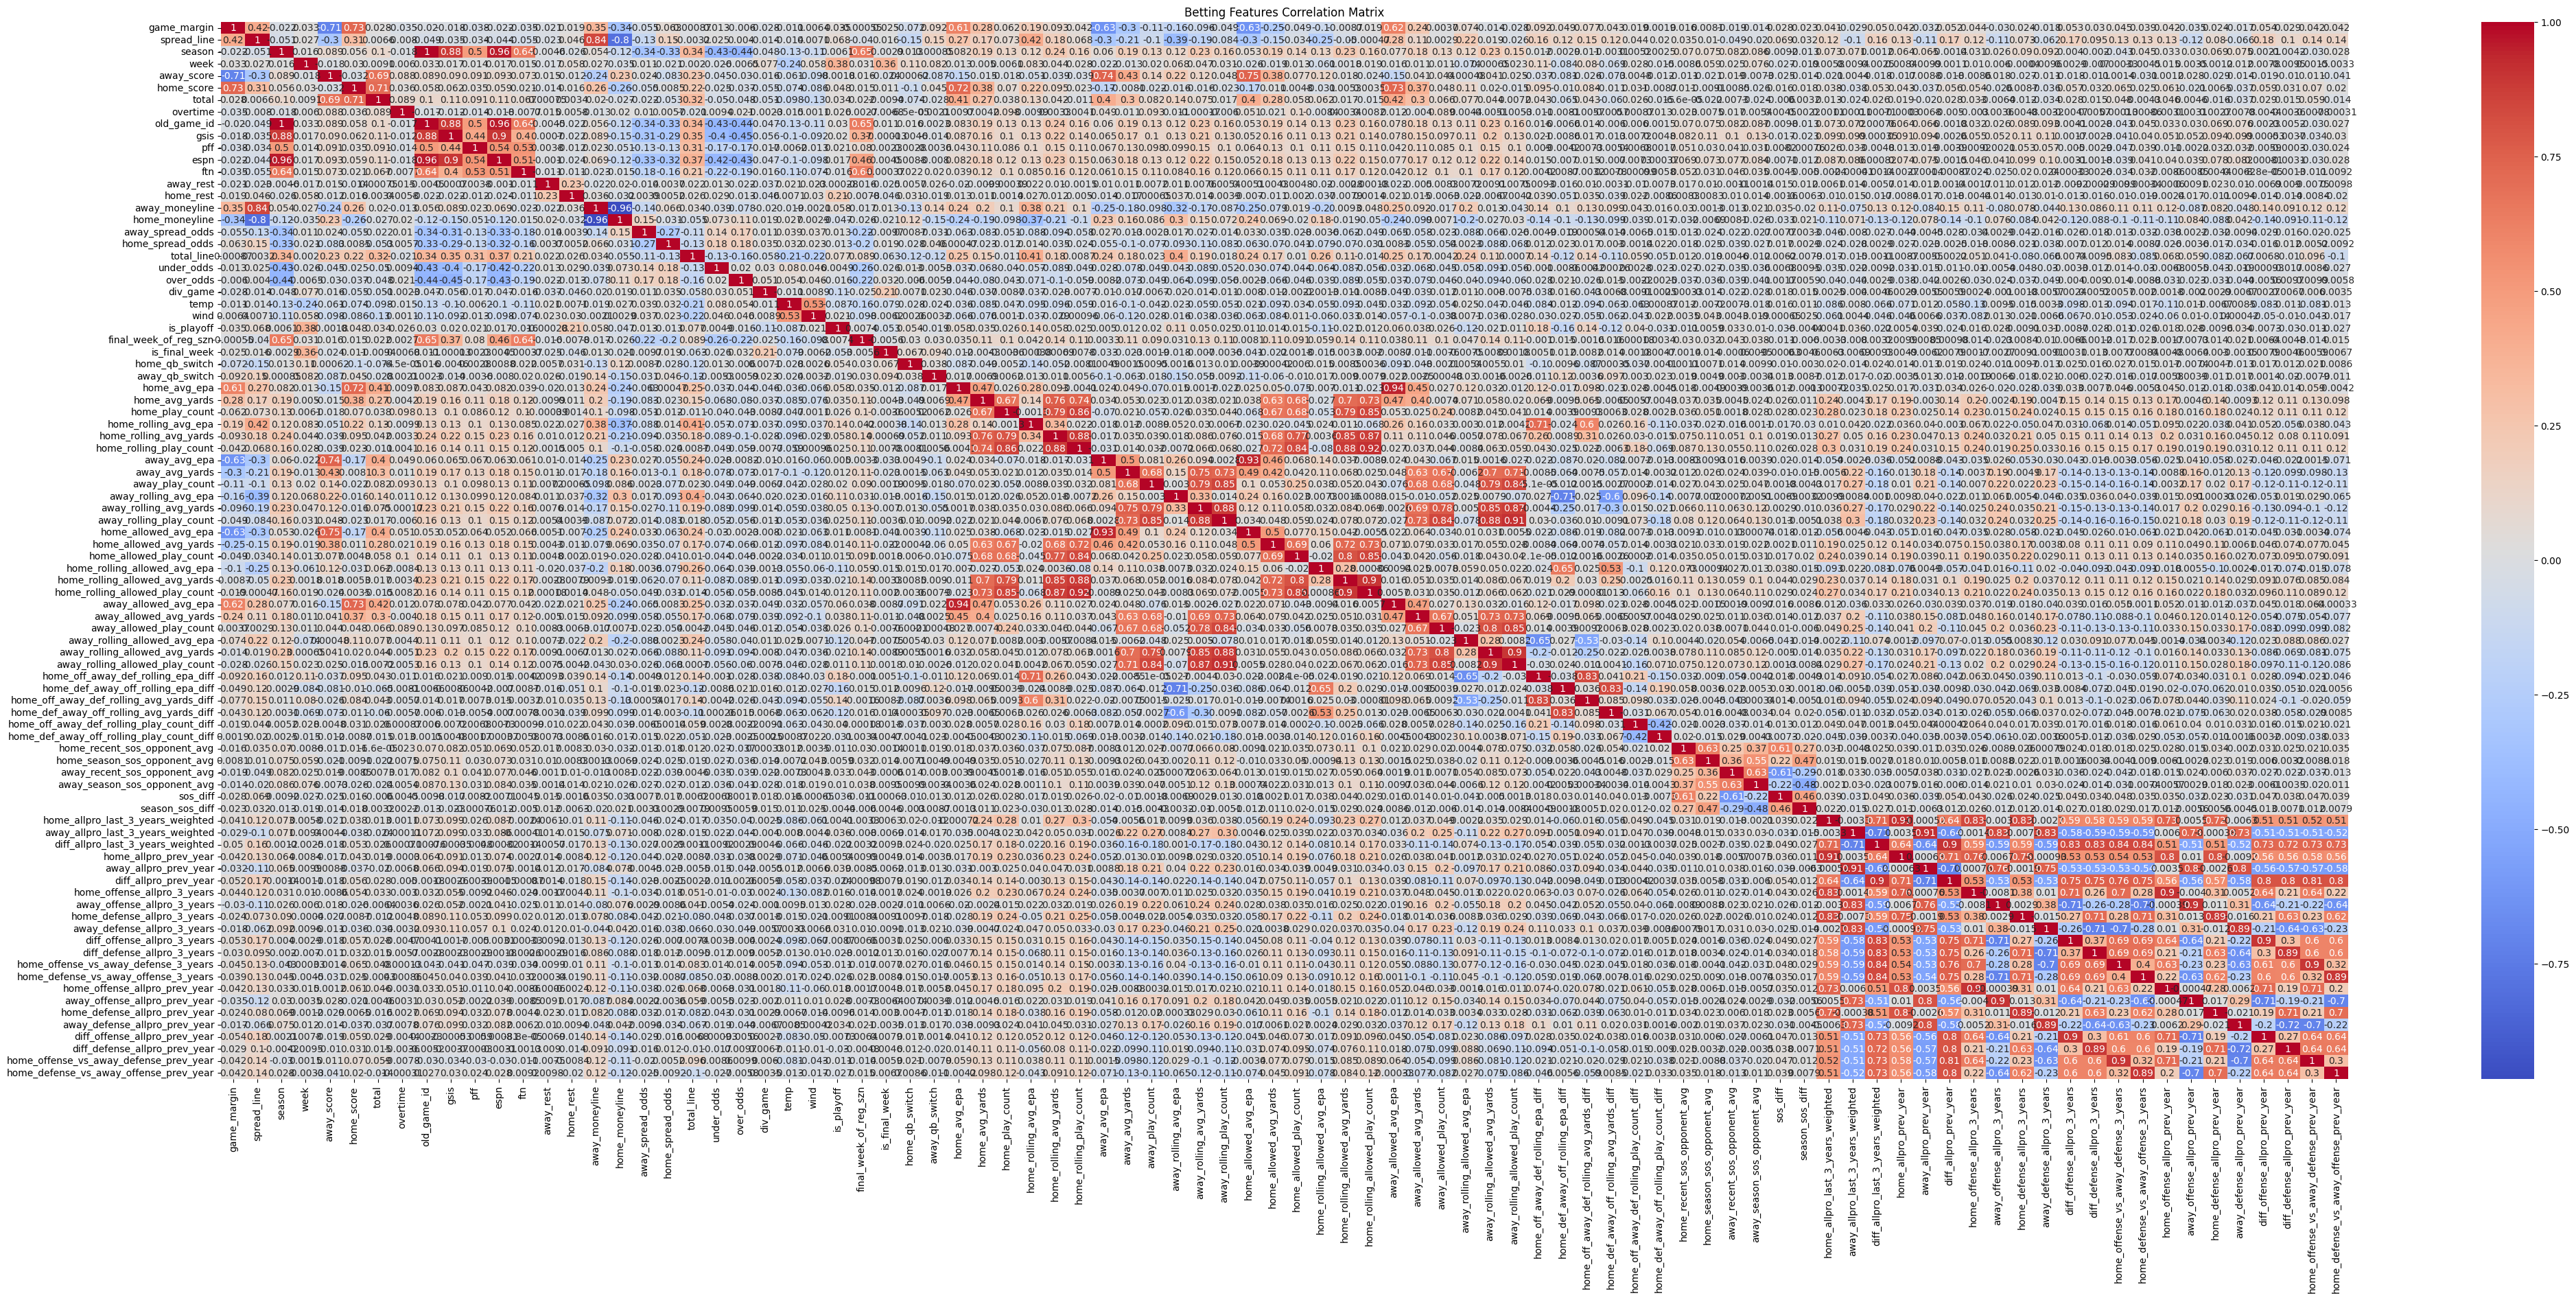

In [38]:
#correlation matrix -> core question: do any of the features in this dataset lead to high margin of victory for home team? or for away team? This is a pointless question as who wins the game would be due to many other factors.
#so would not take much away from this...nonetheless this is good to show for seeing what features might have collinearity.
#This also shows how regression may not be the best suited modeling technique for our project.

#although the recent team performance metrics are going to be correlated with winning or losing so that makes sense

corr_df = match_df.corr(numeric_only=True)
plt.figure(figsize=(50, 20))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title('Betting Features Correlation Matrix')
plt.show()

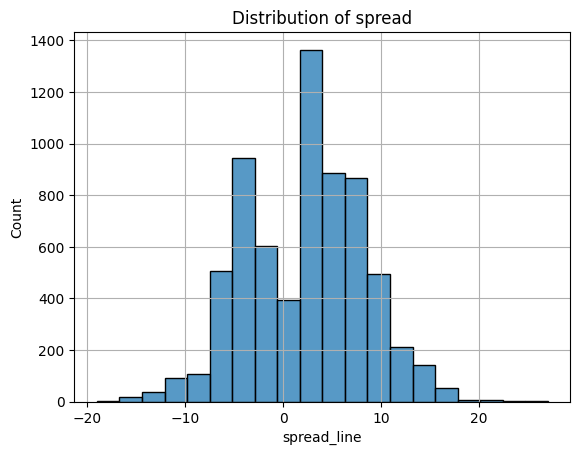

<Figure size 1500x1000 with 0 Axes>

In [39]:
#distribution of target variable. most spreads tend to be within 10 points of zero
sns.histplot(match_df['spread_line'], bins=20)
plt.grid(True)
plt.title('Distribution of spread')
plt.figure(figsize=(15, 10))
plt.show()

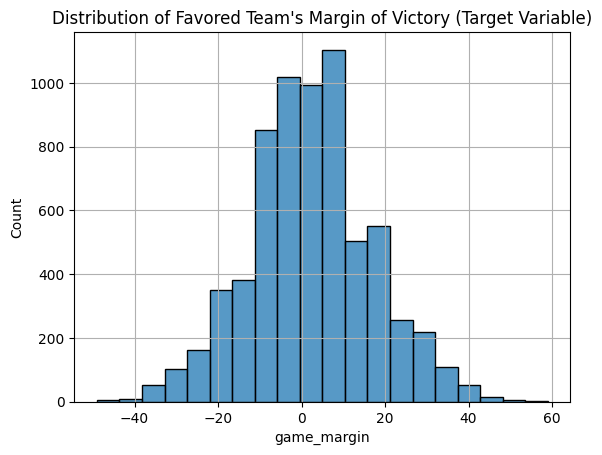

<Figure size 1500x1000 with 0 Axes>

In [40]:
#distribution of game_margin. most margins of victory are between 20 points of zero. As you can see margin of victory has a larger range compared to spread line
sns.histplot(match_df['game_margin'], bins=20)
plt.grid(True)
plt.title("Distribution of Favored Team's Margin of Victory (Target Variable)")
plt.figure(figsize=(15, 10))
plt.show()

In [41]:
# needs to match for features_df
match_df = match_df.rename(columns={'final_week_of_reg_szn': 'final_week'})
match_df.head()

game_id  game_margin  spread_line  season game_type  week  \
0   2000_01_SF_ATL          8.0          6.5    2000       REG     1   
1  2000_01_JAX_CLE        -20.0        -10.5    2000       REG     1   
2   2000_01_IND_KC        -13.0         -3.5    2000       REG     1   
3  2000_01_CHI_MIN          3.0          4.5    2000       REG     1   
4    2000_01_TB_NE         -5.0         -3.0    2000       REG     1   

      gameday weekday gametime away_team  away_score home_team  home_score  \
0  2000-09-03  Sunday    13:00        SF        28.0       ATL        36.0   
1  2000-09-03  Sunday    13:00       JAX        27.0       CLE         7.0   
2  2000-09-03  Sunday    13:00       IND        27.0        KC        14.0   
3  2000-09-03  Sunday    13:00       CHI        27.0       MIN        30.0   
4  2000-09-03  Sunday    13:00        TB        21.0        NE        16.0   

  location  total  overtime  old_game_id    gsis nfl_detail_id           pfr  \
0     Home   64.0       0.0   2000090310   998.0             0  200009030atl   
1     Home   34.0       0.0   2000090306   994.0             0  200009030cle   
2     Home   41.0       0.0   2000090305   993.0             0  200009030kan   
3     Home   57.0       0.0   2000090303   991.0             0  200009030min   
4     Home   37.0       0.0   2000090312  1000.0             0  200009030nwe   

   pff         espn  ftn  away_rest  home_rest  away_moneyline  \
0  0.0  200903001.0  0.0          7          7             0.0   
1  0.0  200903005.0  0.0          7          7             0.0   
2  0.0  200903012.0  0.0          7          7             0.0   
3  0.0  200903016.0  0.0          7          7             0.0   
4  0.0  200903017.0  0.0          7          7             0.0   

   home_moneyline  away_spread_odds  home_spread_odds  total_line  under_odds  \
0             0.0               0.0               0.0        46.5         0.0   
1             0.0               0.0               0.0        38.5         0.0   
2             0.0               0.0               0.0        44.0         0.0   
3             0.0               0.0               0.0        46.5         0.0   
4             0.0               0.0               0.0        36.0         0.0   

   over_odds  div_game      roof    surface  temp  wind  away_qb_id  \
0        0.0         1      dome  astroturf   0.0   0.0  00-0005755   
1        0.0         1  outdoors      grass  78.0   6.0  00-0002110   
2        0.0         0  outdoors      grass  90.0   5.0  00-0010346   
3        0.0         1      dome  astroturf   0.0   0.0  00-0011044   
4        0.0         0  outdoors      grass  71.0   5.0  00-0009266   

   home_qb_id    away_qb_name      home_qb_name      away_coach  \
0  00-0002876     Jeff Garcia    Chris Chandler  Steve Mariucci   
1  00-0003535    Mark Brunell         Tim Couch    Tom Coughlin   
2  00-0006300  Peyton Manning       Elvis Grbac        Jim Mora   
3  00-0003739     Cade McNown  Daunte Culpepper     Dick Jauron   
4  00-0001361      Shaun King      Drew Bledsoe      Tony Dungy   

           home_coach         referee stadium_id  \
0          Dan Reeves    Walt Coleman      ATL00   
1        Chris Palmer    Bernie Kukar      CLE00   
2  Gunther Cunningham   Larry Nemmers      KAN00   
3        Dennis Green      Ed Hochuli      MIN00   
4      Bill Belichick  Jeff Triplette      BOS99   

                        stadium  is_playoff  final_week  is_final_week  \
0                  Georgia Dome       False          17          False   
1      Cleveland Browns Stadium       False          17          False   
2             Arrowhead Stadium       False          17          False   
3  Hubert H. Humphrey Metrodome       False          17          False   
4               Foxboro Stadium       False          17          False   

   home_qb_switch  away_qb_switch  home_avg_epa  home_avg_yards  \
0           False           False     -0.022547        5.698413   
1           False     

In [42]:
#drop columns that we are not using as features in the initial dataset, only take data after week 3 because we don't have rolling data before then that is very accurate

features_df = match_df[match_df['week'] >= 3][['game_margin', 'away_rest', 'home_rest', 'total_line', 'div_game', 'roof', 'surface', 'temp', 'wind', 'home_qb_name', 'away_qb_name', 'away_coach', 'home_coach', 'referee', 'stadium_id', 'is_playoff', 'final_week',
                                               'home_qb_switch', 'away_qb_switch', 'home_rolling_avg_epa', 'home_rolling_avg_yards', 'home_rolling_play_count', 'away_rolling_avg_epa', 'away_rolling_avg_yards', 'away_rolling_play_count', 'home_rolling_allowed_avg_epa',
                                               'home_rolling_allowed_avg_yards', 'home_rolling_allowed_play_count', 'away_rolling_allowed_avg_epa', 'away_rolling_allowed_avg_yards', 'away_rolling_allowed_play_count', 'home_off_away_def_rolling_epa_diff',
                                               'home_def_away_off_rolling_epa_diff', 'home_off_away_def_rolling_avg_yards_diff', 'home_def_away_off_rolling_avg_yards_diff', 'home_off_away_def_rolling_play_count_diff', 'home_def_away_off_rolling_play_count_diff',
                                               'sos_diff','season_sos_diff', 'home_allpro_last_3_years_weighted', 'away_allpro_last_3_years_weighted', 'diff_allpro_last_3_years_weighted', 'home_allpro_prev_year', 'away_allpro_prev_year', 'diff_allpro_prev_year','diff_offense_allpro_3_years'
                                               , 'diff_defense_allpro_3_years', 'home_offense_vs_away_defense_3_years', 'home_defense_vs_away_offense_3_years', 'diff_offense_allpro_prev_year', 'diff_defense_allpro_prev_year', 'home_offense_vs_away_defense_prev_year', 'home_defense_vs_away_offense_prev_year' ]]

print(features_df.shape)

#drop nan values for any feature
features_df = features_df.dropna()

print(features_df.shape)
features_df

(5939, 53)
(5939, 53)


game_margin  away_rest  home_rest  total_line  div_game      roof  \
30           -5.0          7          7        48.5         1  outdoors   
31            3.0         14          7        35.5         1  outdoors   
32          -21.0          7          7        34.5         1      dome   
33            3.0          7          7        42.5         0  outdoors   
34           13.0          7          7        41.0         1  outdoors   
...           ...        ...        ...         ...       ...       ...   
6727          6.0          6          7        43.5         0  outdoors   
6728          2.0          8          7        51.5         0  outdoors   
6729         32.0          8          7        46.5         1  outdoors   
6730          3.0          7          8        49.5         0  outdoors   
6731         18.0         14         14        48.5         0      dome   

        surface  temp  wind     home_qb_name      away_qb_name  \
30        grass  63.0   3.0  Steve Beuerlein    Chris Chandler   
31        grass  67.0  12.0        Tim Couch       Kent Graham   
32    astroturf   0.0   0.0    Charlie Batch        Shaun King   
33        grass  67.0   9.0      Brett Favre    Donovan McNabb   
34        grass  71.0   5.0     Mark Brunell       Akili Smith   
...         ...   ...   ...              ...               ...   
6727      grass  34.0   8.0      Jalen Hurts  Matthew Stafford   
6728     a_turf  19.0   4.0       Josh Allen     Lamar Jackson   
6729      grass  40.0  11.0      Jalen Hurts    Jayden Daniels   
6730      grass  31.0   8.0  Patrick Mahomes        Josh Allen   
6731  sportturf   0.0   0.0      Jalen Hurts   Patrick Mahomes   

          away_coach      home_coach         referee stadium_id  is_playoff  \
30        Dan Reeves  George Seifert   Larry Nemmers      CAR00       False   
31       Bill Cowher    Chris Palmer     Bob McElwee      CLE00       False   
32        Tony Dungy      Bobby Ross    Gerry Austin      DET99       False   
33         Andy Reid    Mike Sherman   Tony Corrente      GNB00       False   
34      Bruce Coslet    Tom Coughlin      Ed Hochuli      JAX00       False   
...              ...             ...             ...        ...         ...   
6727      Sean McVay   Nick Sirianni     Shawn Smith      PHI00        True   
6728   John Harbaugh  Sean McDermott   Carl Cheffers      BUF00        True   
6729       Dan Quinn   Nick Sirianni   Shawn Hochuli      PHI00        True   
6730  Sean McDermott       Andy Reid  Clete Blakeman      KAN00        True   
6731       Andy Reid   Nick Sirianni     Ron Torbert      NOR00        True   

      final_week  home_qb_switch  away_qb_switch  home_rolling_avg_epa  \
30            17           False           False              0.133196   
31            17           False           False             -0.002257   
32            17           False           False             -0.350363   
33            17           False           False             -0.107729   
34            17           False           False              0.130360   
...          ...             ...             ...                   ...   
6727          18           False           False              0.100234   
6728          18           False           False              0.188274   
6729          18           False           False              0.077039   
6730          18           False           False             -0.004269   
6731          18           False           False              0.151505   

      home_rolling_avg_yards  home_rolling_play_count  away_rolling_avg_epa  \
30                  5.671569                     59.5             -0.214090   
31                  5.631133                     53.5             -0.304014   
32                  3.542163                     56.5              0.087625   
33                  4.532913                     53.5              0.099073   
34                  5.395877                     76.0             -0.077299   


##Modeling

###Random Forest

The goal of this initial RF Regressor Model is to reduce the features that we are using in future models and further in our project. Right now we are using too many features and need to hone down on more influential features that impact game margin.

In the initial run through, the goal is not to have an incredibly well performing model.

Sources

https://www.geeksforgeeks.org/machine-learning/categorical-data-encoding-techniques-in-machine-learning/

https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [44]:
def random_forest_regressor(features_df):

    #features
    X = features_df.drop(columns='game_margin')
    #target variable
    y = features_df['game_margin']

    #random forest model only works with numbers so we need to encode categorical features into a number of some sort
    #Using One Hot Encoding because while none of the categorical variables have an order to them we don't want the model to pick up any 'fake ordering'
    #converts each category to binary value
    cat_features = X.select_dtypes(include='object').columns.tolist()
    quan_features = X.select_dtypes(exclude='object').columns.tolist()

    print(cat_features)
    print('\n\n')
    print(quan_features)
    print('\n\n')

    #encode categorical features
    cat_feature_encoding = ColumnTransformer([("cat_features", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)], remainder='passthrough')

    X_encoded = cat_feature_encoding.fit_transform(X)
    new_cat_feat_names = cat_feature_encoding.named_transformers_['cat_features'].get_feature_names_out(cat_features)
    updated_feats = list(new_cat_feat_names) + list(quan_features)
    X_updated = pd.DataFrame(X_encoded, columns=updated_feats)
    X_updated = X_updated.astype(float)

    print(X_updated.columns)
    print('\n\n')

    X_train, X_test, y_train, y_test = train_test_split(X_updated, y, test_size=0.2, random_state=3)

    rf_reg = RandomForestRegressor(n_estimators=100, random_state=3)
    rf_reg.fit(X_train, y_train)

    y_pred = rf_reg.predict(X_test)

    print("MAE:")
    print(mean_absolute_error(y_test, y_pred))
    print('\n\n')

    print("R²:")
    print(r2_score(y_test, y_pred))
    print('\n\n')

    #Calculating the feature importance
    feature_importance = rf_reg.feature_importances_
    feature_importance = 100.0*(feature_importance/np.sum(feature_importance))

    #Get top 20 feature since there are so many
    top_x = 20
    top_idx = np.argsort(feature_importance)[-top_x:]
    top_idx = top_idx[np.argsort(feature_importance[top_idx])[::-1]]

    updated_feats_arr = np.array(updated_feats)
    top_features = updated_feats_arr[top_idx]

    print(top_features)
    print('\n\n')
    top_importance = feature_importance[top_idx]
    print(top_importance)
    print('\n\n')

    #plotting the top 20 features for my random forest regressor
    plt.figure(figsize=(10, 10))
    plt.barh(np.arange(top_x), top_importance[::-1], color='crimson', align='center')
    plt.yticks(np.arange(top_x), top_features[::-1])
    plt.xlabel('Relative Importance (%)')
    plt.title('RF Reg - Feature Importance - Top 20 Features')
    plt.tight_layout()
    plt.show()

    #drop low importance features and return updated df
    threshold = 0.5
    low_idx = np.where(feature_importance < threshold)[0]
    low_feat_names = np.array(updated_feats)[low_idx].tolist()

    print('\n\n')
    print(f"{len(low_feat_names)} features with importance < {threshold}%")
    print('\n\n')

    #drop low importance features from encoded X
    X_filtered = X_updated.drop(columns=low_feat_names)

    # Combine with y and return
    updated_df = pd.concat([X_filtered, y.reset_index(drop=True)], axis=1)
    return rf_reg, updated_df, low_feat_names

In [ ]:
init_model = random_forest_regressor(features_df)

The MAE for our model is 10.94 which means, on average, our model predicted a game margin off by approximately 10.94 points from the real value.

Typically, NFL game margins are single digit. This means we are performing worse than just predicting the mean margin. NFL games are noisy. Game margins can vary heavily by just one play.

An R-squared score of 5.41% means our model explains 5.41% of the variance in game margin. This is low, but not unexpected as the NFL and sports in general are very noisy.

Even though we have a weak model, it minimized error based on the features given. Shows which features are important overall.

Based off our model and feature importance report:

Drop the bottom ~20% of features (those with near-zero importance). Hopefully this will lessen overfitting and increase generalization.

The top features are all heavily correlated...check multicollinearity and if two features are highly correlated, drop one of them / combine them.

Focus and refine on top 5 to 10 features. Fully flesh out those features in whatevery ways necessary. Do they need better encoding? Do we need to modify the feature or add a similar feature to enhance the model? Change window size for rolling stats?

Looking at feature importance from other models can give us a good understanding of commonality in features among them.

For instance, one thing adjusted after an initial look at the model is combining rolling epa, rolling avg yards, and rolling play count of away and home teams into a two differential feature for each category. One differential is home offense vs away defense. The other is away offense vs home defense.

We also combined some other away vs home team features into diff features to reduce feature count.

This should clear up clutter and reduce high correlation between features.

['roof', 'surface', 'home_qb_name', 'away_qb_name', 'away_coach', 'home_coach', 'referee', 'stadium_id']



['away_rest', 'home_rest', 'total_line', 'div_game', 'temp', 'wind', 'is_playoff', 'final_week', 'home_qb_switch', 'away_qb_switch', 'home_off_away_def_rolling_epa_diff', 'home_def_away_off_rolling_epa_diff', 'home_off_away_def_rolling_avg_yards_diff', 'home_def_away_off_rolling_avg_yards_diff', 'home_off_away_def_rolling_play_count_diff', 'home_def_away_off_rolling_play_count_diff', 'sos_diff', 'season_sos_diff', 'diff_allpro_prev_year']



Index(['roof_closed', 'roof_dome', 'roof_open', 'roof_outdoors',
       'surface_a_turf', 'surface_astroplay', 'surface_astroturf',
       'surface_dessograss', 'surface_fieldturf', 'surface_grass',
       ...
       'away_qb_switch', 'home_off_away_def_rolling_epa_diff',
       'home_def_away_off_rolling_epa_diff',
       'home_off_away_def_rolling_avg_yards_diff',
       'home_def_away_off_rolling_avg_yards_diff',
       'home_off_away_def_

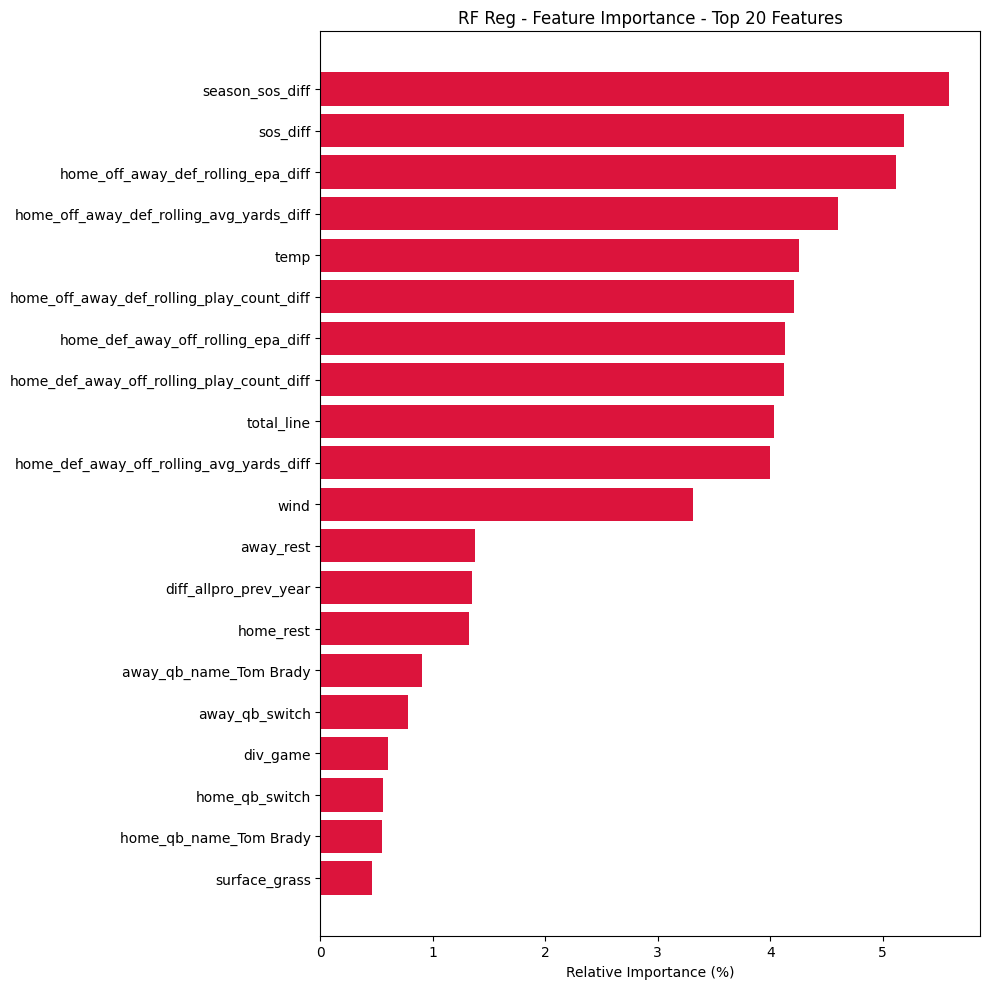




1084 features with importance < 0.5%





In [ ]:
#after RF regressor, updating features to combine epa, avg yards, and play count (home off vs away def and home def vs away off)
reduced_features_df = match_df[match_df['week'] >= 3][['game_margin', 'away_rest', 'home_rest', 'total_line', 'div_game', 'roof', 'surface', 'temp', 'wind', 'home_qb_name', 'away_qb_name', 'away_coach', 'home_coach', 'referee', 'stadium_id', 'is_playoff', 'final_week',
                                               'home_qb_switch', 'away_qb_switch', 'home_off_away_def_rolling_epa_diff', 'home_def_away_off_rolling_epa_diff', 'home_off_away_def_rolling_avg_yards_diff', 'home_def_away_off_rolling_avg_yards_diff', 'home_off_away_def_rolling_play_count_diff',
                                               'home_def_away_off_rolling_play_count_diff', 'sos_diff','season_sos_diff', 'diff_allpro_prev_year']] #use whichever feature has model perform better - 'diff_allpro_prev_year' vs. 'diff_allpro_last_3_years_weighted'

#all pro prev year mae = 10.63. r2 = .0903, all pro last 3 years weighted mae = 10.66, r2 = .0803 -> keep all pro prev year


rf_reg, updated_df, dropped_features= random_forest_regressor(reduced_features_df)

The MAE for our model is 10.63 which means, on average, our model predicted a game margin off by approximately 10.63 points from the real value.

Better than our previous model.

An R-squared score of 9.04% means our model explains 9.04% of the variance in game margin. This is a slight decrease from the previous model.

Hard to take much away as collinearity can actually help random forest models by removing noise.

By looking at our feature importance, it looks a lot more diverse after combining some of the highly correlated features. This is good for a more genearlized model moving further into our project.

Next, we can improve the feature set even further if we remove the bottom features.

In [ ]:
def random_forest_regressor(features_df):

    #features
    X = features_df.drop(columns='game_margin')
    #target variable
    y = features_df['game_margin']

    X_updated = X.astype(float)

    print(X_updated.columns)
    print('\n\n')

    X_train, X_test, y_train, y_test = train_test_split(X_updated, y, test_size=0.2, random_state=3)

    rf_reg = RandomForestRegressor(n_estimators=100, random_state=3)
    rf_reg.fit(X_train, y_train)

    y_pred = rf_reg.predict(X_test)

    print("MAE:")
    print(mean_absolute_error(y_test, y_pred))
    print('\n\n')

    print("R²:")
    print(r2_score(y_test, y_pred))
    print('\n\n')

    #Calculating the feature importance
    feature_importance = rf_reg.feature_importances_
    feature_importance = 100.0*(feature_importance/np.sum(feature_importance))

    #Get top 20 feature since there are so many
    '''top_x = 20
    top_idx = np.argsort(feature_importance)[-top_x:]
    top_idx = top_idx[np.argsort(feature_importance[top_idx])[::-1]]

    updated_feats_arr = np.array(X_updated.columns)
    top_features = updated_feats_arr[top_idx]

    print(top_features)
    print('\n\n')
    top_importance = feature_importance[top_idx]
    print(top_importance)
    print('\n\n')

    #plotting the top 20 features for my random forest regressor
    plt.figure(figsize=(10, 10))
    plt.barh(np.arange(top_x), top_importance[::-1], color='crimson', align='center')
    plt.yticks(np.arange(top_x), top_features[::-1])
    plt.xlabel('Relative Importance (%)')
    plt.title('RF Reg - Feature Importance - Top 20 Features')
    plt.tight_layout()
    plt.show()'''

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)[::-1]
    features = np.array(X_updated.columns)[sorted_idx]
    imp = feature_importance[sorted_idx]

    '''print("Top Features by Importance:")
    for name, score in zip(features, imp):
        print(f"{name}: {score:.2f}%")'''

    print('\n\n')

    # Plot all feature importances
    plt.figure(figsize=(12, max(6, 0.25 * len(features))))  # dynamic height
    plt.barh(np.arange(len(features)), imp[::-1], color='crimson', align='center')
    plt.yticks(np.arange(len(features)), features[::-1])
    plt.xlabel('Relative Importance (%)')
    plt.title('RF Regressor - Feature Importance')
    plt.tight_layout()
    plt.show()

    #drop low importance features and return updated df
    threshold = 0.5
    low_idx = np.where(feature_importance < threshold)[0]
    low_feat_names = np.array(X_updated.columns)[low_idx].tolist()

    print('\n\n')
    print(f"{len(low_feat_names)} features with importance < {threshold}%")
    print('\n\n')

    #drop low importance features from encoded X
    X_filtered = X_updated.drop(columns=low_feat_names)

    # Combine with y and return
    updated_df = pd.concat([X_filtered, y.reset_index(drop=True)], axis=1)
    return rf_reg, updated_df, low_feat_names

Index(['home_qb_name_Tom Brady', 'away_qb_name_Tom Brady', 'away_rest',
       'home_rest', 'total_line', 'div_game', 'temp', 'wind', 'home_qb_switch',
       'away_qb_switch', 'home_off_away_def_rolling_epa_diff',
       'home_def_away_off_rolling_epa_diff',
       'home_off_away_def_rolling_avg_yards_diff',
       'home_def_away_off_rolling_avg_yards_diff',
       'home_off_away_def_rolling_play_count_diff',
       'home_def_away_off_rolling_play_count_diff', 'sos_diff',
       'season_sos_diff', 'diff_allpro_prev_year'],
      dtype='object')



MAE:
11.064360269360268



R²:
0.019680475063538316








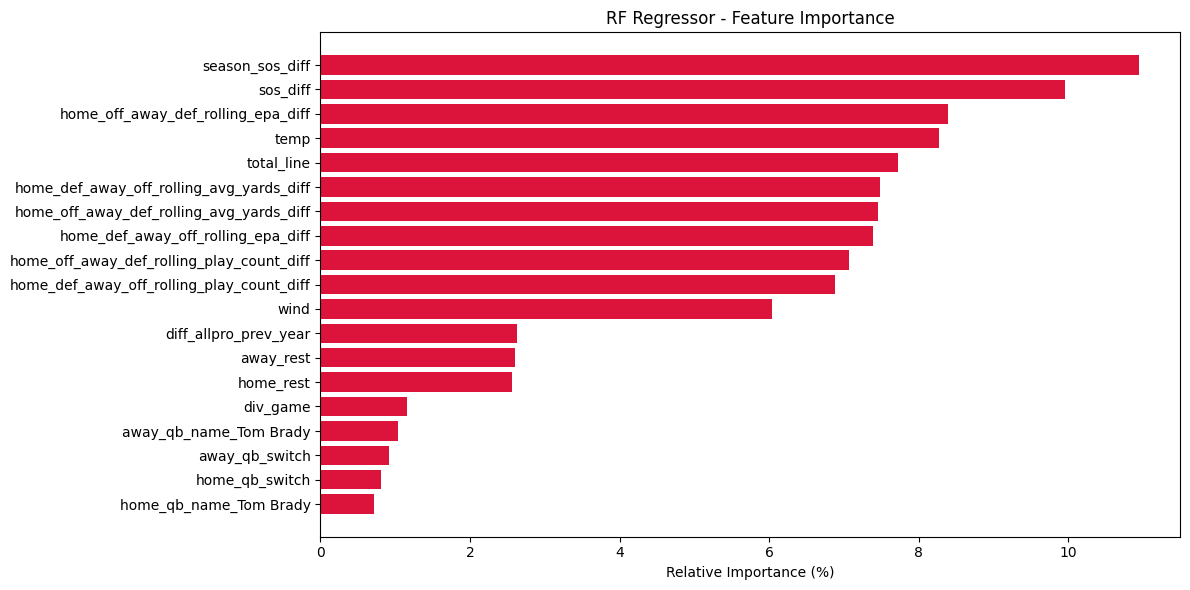




0 features with importance < 0.5%





In [ ]:
#after RF regressor, updating features to combine epa, avg yards, and play count (home off vs away def and home def vs away off)
top_features_rf_reg, top_features_df, dropped_features = random_forest_regressor(updated_df)

When we filter for only features that were above .5 feature importance for our model in the previous feature set...

The MAE for our model is 11.06 which means, on average, our model predicted a game margin off by approximately 11.06 points from the real value.

An R-squared score of 1.97% means our model explains 1.97% of the variance in game margin. This is a significant decrease from the previous model.

The smaller features seem to more impactful that we may have thought.

Next, we will look at add some of those features back and refining the top features.